# Glycocalyx - Salt Interface Alternate SIP/CIP Simulation


## 1. Steady State Equations

### 1.1 Salt Layer

The equation for the gel layer is a non-linear 2nd order ordinary differential equation.

$$ \frac{d^2\phi_D(x)}{dx^2} = \frac{c_{i,o}}{c_{j,o}} \left( e^{\phi_D(x)}-e^{-\phi_D(x)} \right) $$


### 1.2 Gel Layer

The equation for the gel layer is a non-linear 2nd order ordinary differential equation.

$$ \frac{d^2\phi_D(x)}{dx^2} = \frac{c_{i,o}}{c_{j,o}} \left( e^{\phi_D(x)}-e^{-\phi_D(x)} \right) + \left[ 1+ \frac{c_{i,o}}{K_{ij}}( 1+ \frac{1}{K_2})e^{-\phi_D(x)} \right]^{-1} $$

For the purpose of making the code readable, I am substituting the names of the variables such that this equation becomes:

$$ y'' = S \left( e^{y}-e^{-y} \right) + \left[ 1+ P (1+Q) e^{-y} \right]^{-1} $$

$$ Q = 1/K_2 $$
 
And using the definition of the hyperbolic sine, this becomes further simplified to:

$$ y'' =  S \cdot 2\sinh y + \left[ 1+ P (1+Q) e^{-y} \right]^{-1} $$




## 2. Steady State Simulation
### 2.1 'Jump' Conditions
Determine the value at $y(x \rightarrow \infty)$ using function solver

In [6]:
# --------------------------
# import libraries
# --------------------------
import numpy as np
from scipy.integrate import solve_bvp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# --------------------------
# define and determine constants
# --------------------------
# initialize constants selected to match the Matlab code
S = 0.1 # screening (c_i,o / c_j,o)
P = 0.1 # pairing   (c_i,o / K_ij)
Q = 0.1 # secondary SIP to CIP reaction (1 / K_2)
# calculate y(x->inf) assuming y''(x->inf)=0
def gel(y):
    return S*(np.exp(y)-np.exp(-y)) + (1+P*(1+Q)*np.exp(-y))**-1
y_inf = fsolve(gel,-2)[0]
print(y_inf)

-1.8138587706399745


### 2.2 Optimization of Intercept
Run code to find intercept such that the slopes of the salt layer and gel layer are matched.

In [7]:
# --------------------------
# Loop through potential intercepts
# and optimize for minimum difference in slope at interface
# --------------------------
min_d_slope = 100 # minimum difference in slope
min_intercept = 0 # intercept associated with min_d_slope
dx= 0.05
testrange = np.arange(-10, 10 + dx, dx)
for y0 in np.arange(0, y_inf, -0.001):
    # SALT LAYER
    # --------------------------
    def fun_s(x, y):
        z  = y[1]
        dz = S*2*np.sinh(y[0])
        return np.vstack((z, dz))

    def bc_s(ya, yb):
        return np.array([ya[0]-y0, yb[0]])

    xs = np.arange(0, 10+dx, dx)
    ys = -np.ones((2, xs.size))
    res = solve_bvp(fun_s, bc_s, xs, ys)
    ys = res.sol(xs)[0]
    slope_salt = (ys[1]-ys[0]) / (xs[1]-xs[0])
    
    # GEL LAYER
    # --------------------------
    def fun(x, y):
        z  = y[1]
        dz = S*2*np.sinh(y[0]) + (1+P*(1+Q)*np.exp(-y[0]))**(-1)
        return np.vstack((z, dz))

    def bc(ya, yb):
        return np.array([ya[0]-y_inf, yb[0]-y0])

    x = np.arange(-10, 0+dx, dx)
    y = -np.ones((2, x.size))
    res = solve_bvp(fun, bc, x, y)
    y = res.sol(x)[0]
    slope_gel = (y[-1]-y[-2]) / (x[-1]-x[-2])
    
    # OPTIMIZATION
    # --------------------------
    d_slope = abs(slope_salt-slope_gel)
    if d_slope <= min_d_slope:
        min_d_slope = d_slope
        min_intercept = y0
        
        
print(min_d_slope, min_intercept)

0.0006173747636750715 -1.17


### 2.3 Re-solve and Plot at Optimal Intercept

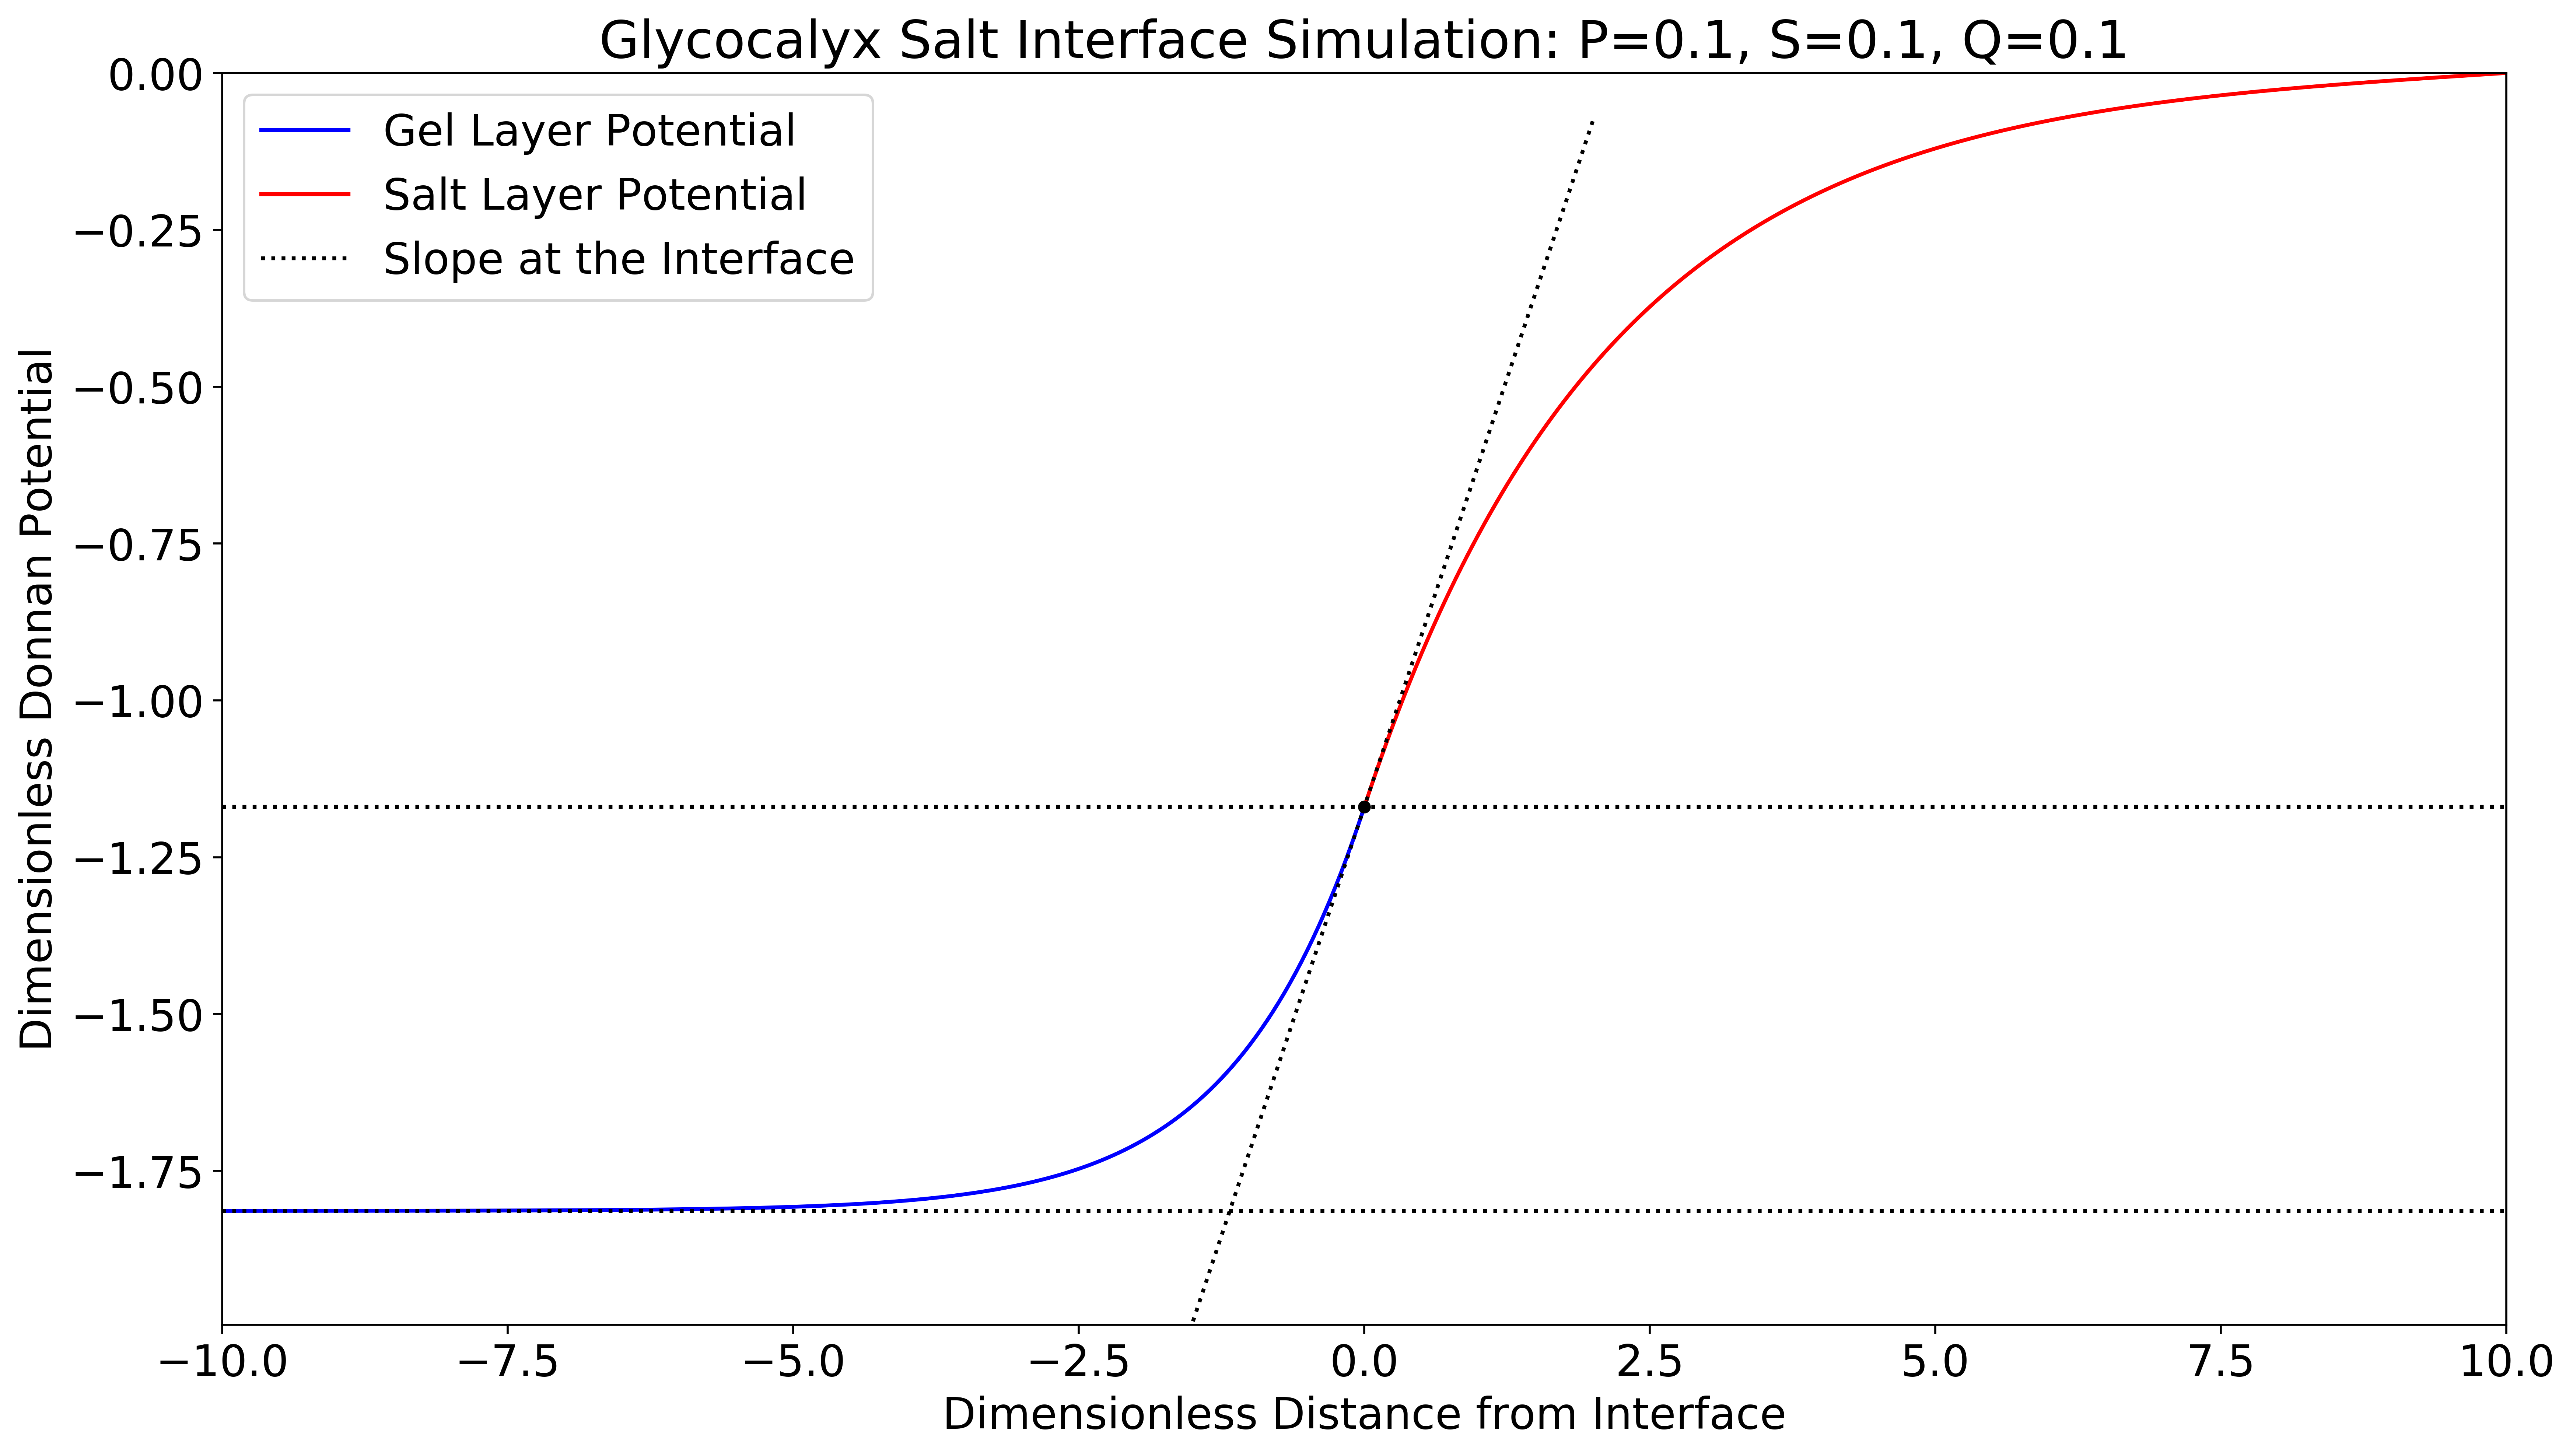

In [8]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
%matplotlib inline

dx = 0.05
y0 = min_intercept

# SALT LAYER
# --------------------------
def fun_s(x, y):
    z  = y[1]
    dz = S*2*np.sinh(y[0])
    return np.vstack((z, dz))

def bc_s(ya, yb):
    return np.array([ya[0]-y0, yb[0]])

xs = np.arange(0, 10+dx, dx)
ys = -np.ones((2, xs.size))
res = solve_bvp(fun_s, bc_s, xs, ys)
ys = res.sol(xs)[0]
# TANGENT LINE
# --------------------------
xi = np.linspace(-2, 2, num=2)
slope = (ys[1]-ys[0]) / (xs[1]-xs[0])
yi = slope*xi+y0


# GEL LAYER
# -------------------------
# Solve the differential equation
def fun(x, y):
    z  = y[1]
    dz = S*2*np.sinh(y[0]) + (1+P*(1+Q)*np.exp(-y[0]))**(-1)
    return np.vstack((z, dz))

def bc(ya, yb):
    return np.array([ya[0]-y_inf, yb[0]-y0])

x = np.arange(-10, 0 + dx, dx)
y = -np.ones((2, x.size))
res = solve_bvp(fun, bc, x, y)
y = res.sol(x)[0]

# PLOT RESULTS
# --------------------------
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(16,9), dpi=500)
plt.plot(x, y, 'b', label = 'Gel Layer Potential')
plt.plot(xs, ys, 'r', label = 'Salt Layer Potential')
plt.plot(xi, yi, 'k:', label = 'Slope at the Interface')
plt.plot(0, y0, 'ko', ms=4) # marker at intercept
plt.plot([x[0], xs[-1]], [y0, y0], 'k:') # marker at intercept
plt.plot([x[0], xs[-1]], [y_inf, y_inf], 'k:')

plt.title('Glycocalyx Salt Interface Simulation: P='+ str(P) + ', S=' + str(S) + ', Q=' +str(Q))
plt.xlabel('Dimensionless Distance from Interface')
plt.ylabel('Dimensionless Donnan Potential')
plt.legend()
plt.xlim(x[0], xs[-1])
plt.ylim(y[0]*1.1, 0)
plt.savefig('steady state SIP CIP.jpg')

## 3. Numerical Analysis

### 3.1 Measurement of Donnan Potential

In [9]:
Donnan = np.hstack((np.hstack((y[:-1], (y[-1] + ys[0])*0.5)), ys[1:]))

Donnan

array([-1.81385877e+00, -1.81385299e+00, -1.81384720e+00, -1.81384138e+00,
       -1.81383553e+00, -1.81382963e+00, -1.81382366e+00, -1.81381761e+00,
       -1.81381148e+00, -1.81380524e+00, -1.81379889e+00, -1.81379240e+00,
       -1.81378578e+00, -1.81377899e+00, -1.81377203e+00, -1.81376488e+00,
       -1.81375753e+00, -1.81374995e+00, -1.81374214e+00, -1.81373408e+00,
       -1.81372574e+00, -1.81371712e+00, -1.81370818e+00, -1.81369892e+00,
       -1.81368932e+00, -1.81367934e+00, -1.81366897e+00, -1.81365819e+00,
       -1.81364698e+00, -1.81363530e+00, -1.81362314e+00, -1.81361046e+00,
       -1.81359724e+00, -1.81358346e+00, -1.81356908e+00, -1.81355406e+00,
       -1.81353839e+00, -1.81352201e+00, -1.81350491e+00, -1.81348703e+00,
       -1.81346835e+00, -1.81344882e+00, -1.81342839e+00, -1.81340703e+00,
       -1.81338469e+00, -1.81336132e+00, -1.81333686e+00, -1.81331127e+00,
       -1.81328449e+00, -1.81325646e+00, -1.81322712e+00, -1.81319640e+00,
       -1.81316425e+00, -

### 3.2 Relevant Graphs of the Donnan Potential

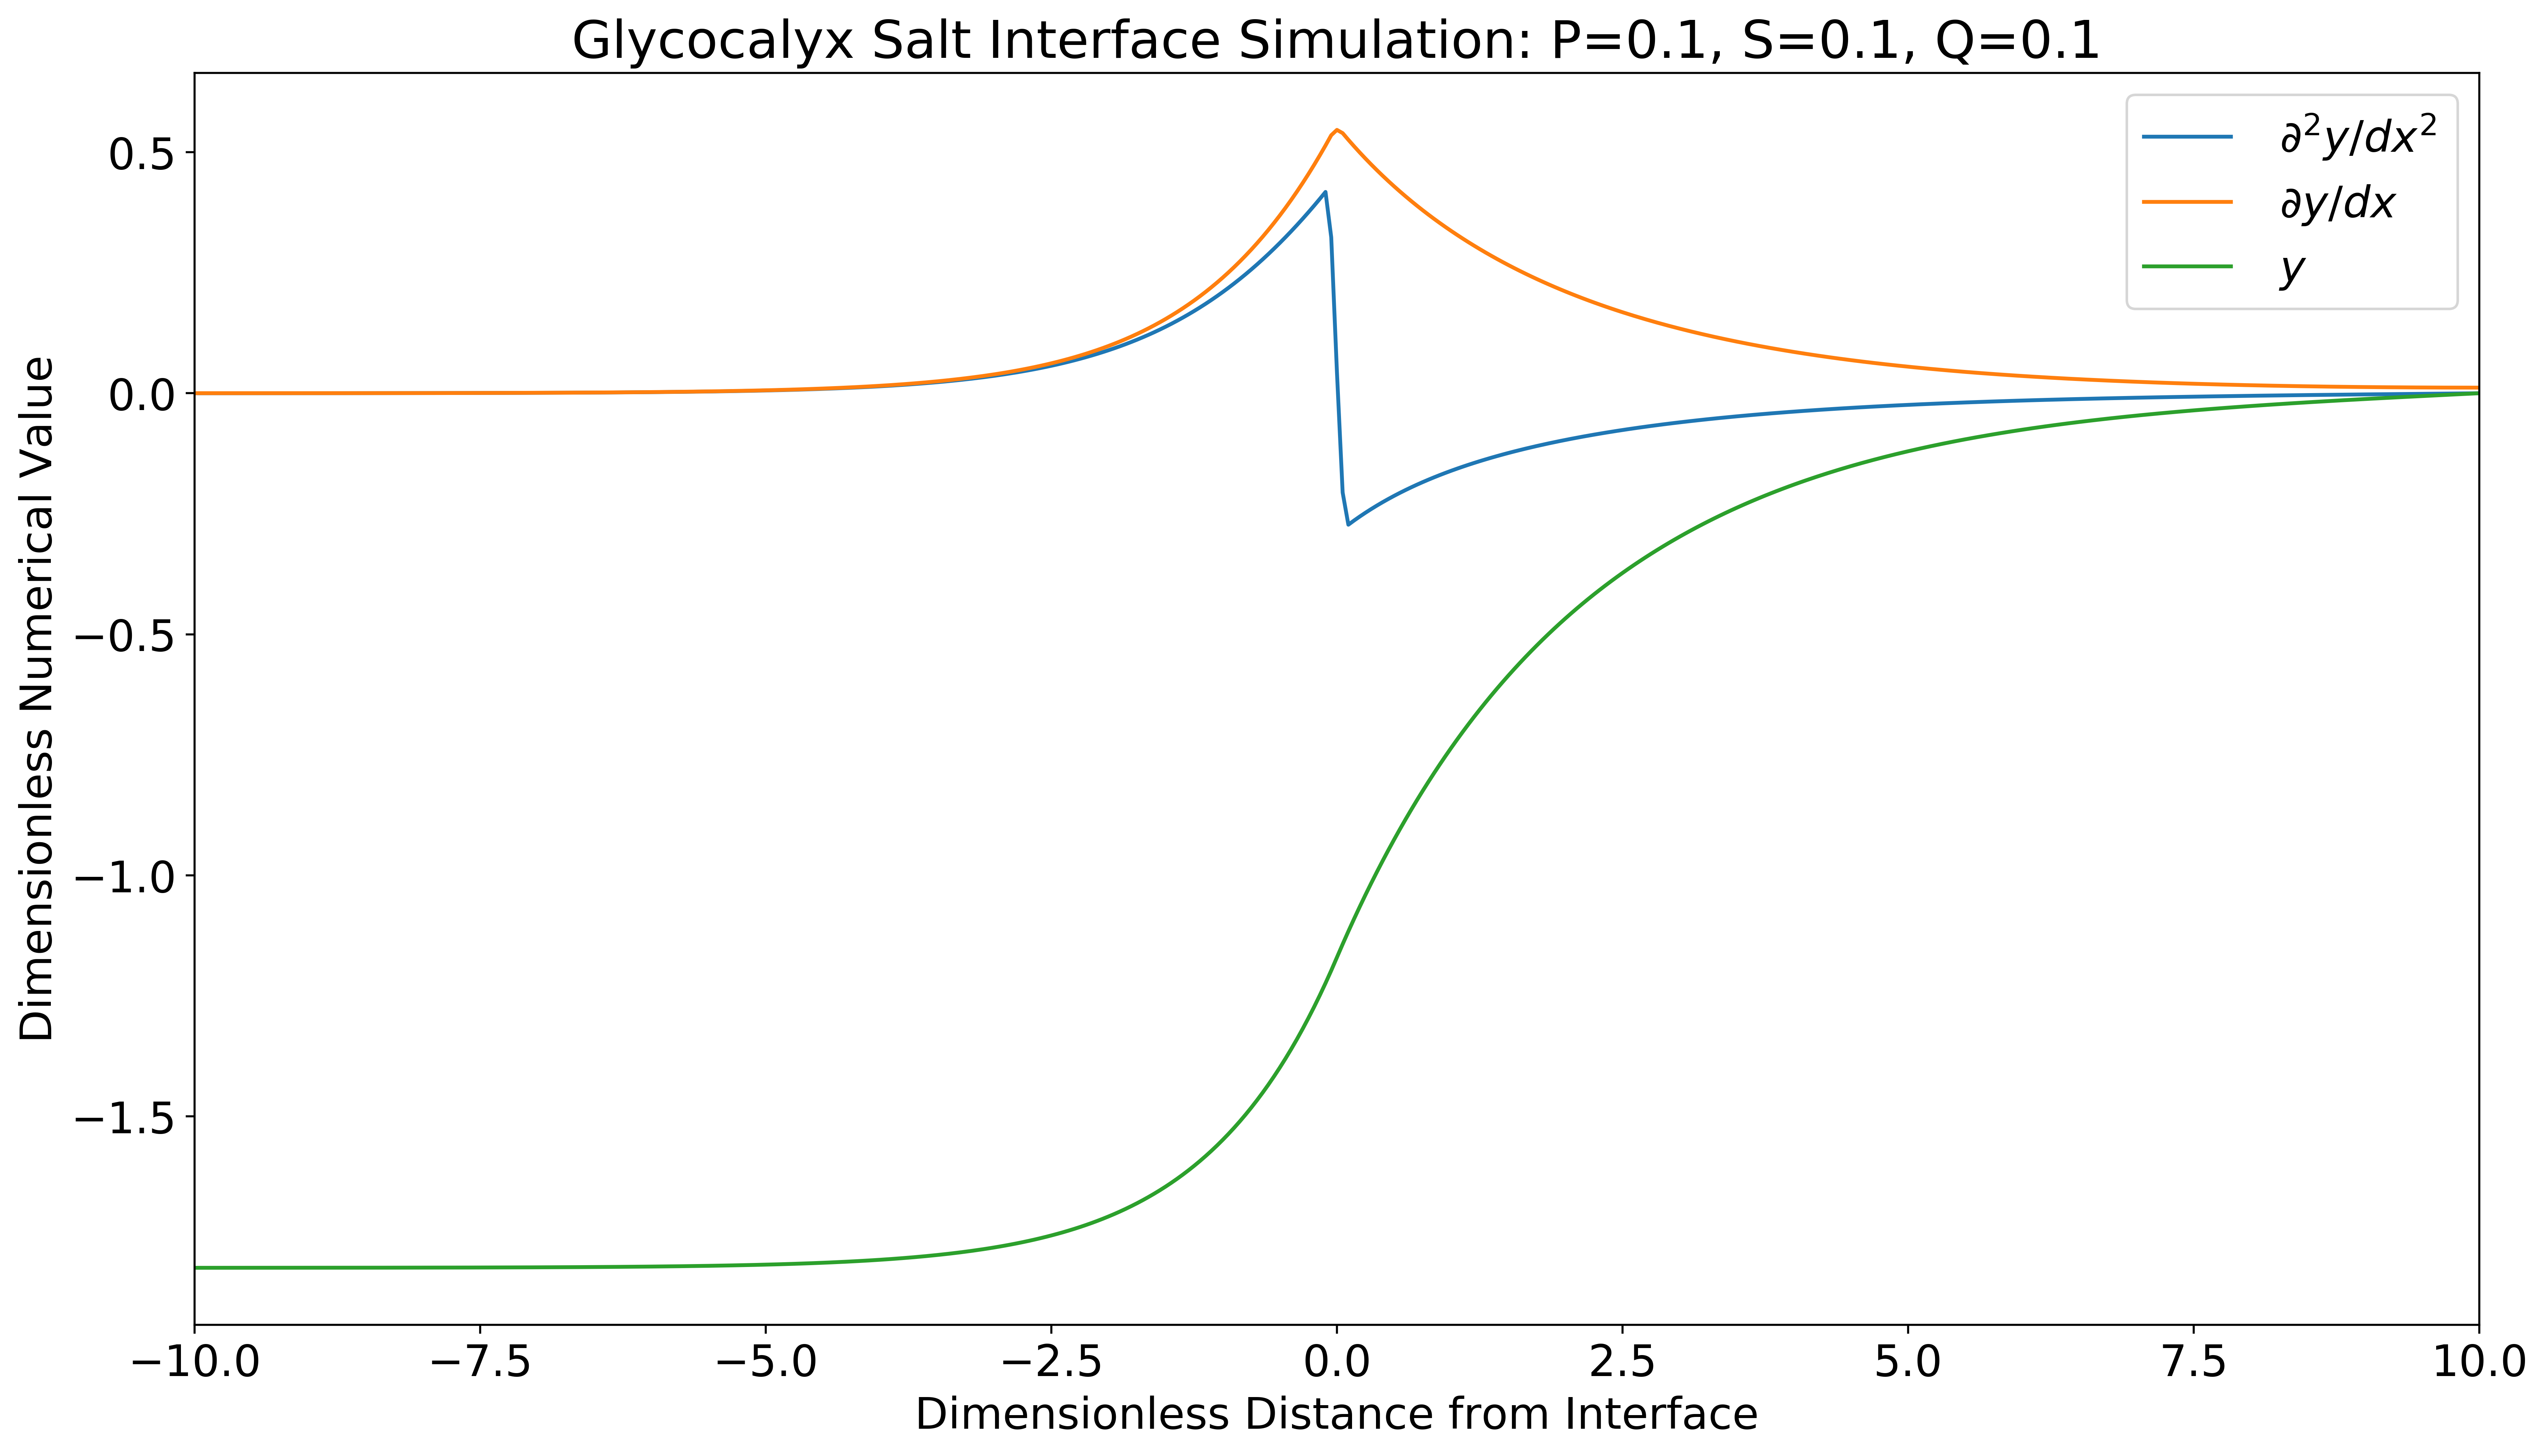

In [10]:
DonnanPrime = np.gradient(Donnan, dx, edge_order = 2)
DonnanDoublePrime = np.gradient(DonnanPrime, dx, edge_order =2)

plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(16,9), dpi=500)
plt.plot(testrange, DonnanDoublePrime, label=r" $\partial^2 y / dx^2$ ")
plt.plot(testrange, DonnanPrime, label = r" $\partial y / dx$ ")
plt.plot(testrange, Donnan, label = r" $y$ ")

plt.title('Glycocalyx Salt Interface Simulation: P='+ str(P) + ', S=' + str(S) + ', Q=' +str(Q))
plt.legend()
plt.xlabel('Dimensionless Distance from Interface')
plt.ylabel('Dimensionless Numerical Value')
plt.xlim(testrange[0], testrange[-1])
plt.savefig('steady state SIP CIP derivs.jpg')